sigma_2_sq = 0.5439223051071167


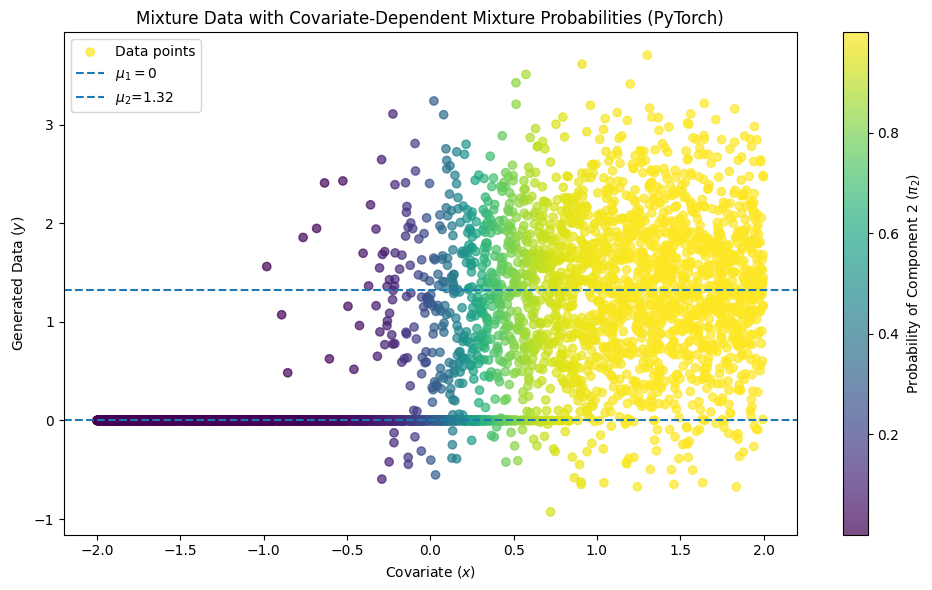

In [1]:
import torch
import matplotlib.pyplot as plt

# ------------------
# Settings & seed
# ------------------
torch.manual_seed(1)
device = torch.device("cpu")  # or "cuda" if you want

n_samples = 5000
a, b = 5.0, -1.0          # logistic coeffs for mixture probs
mu_1 = 0.0
sigma_1_sq = 0.2          # (unused since comp 1 is spike at 0 in this setup)
sd_noise = 1.0

# Random slab params (scalars) like your NumPy version
mu_2 =  torch.normal(mean=torch.tensor(0.0, device=device), std=torch.tensor(2.0, device=device))
sigma_2_sq = torch.empty((), device=device).uniform_(0.5, 2.0)  # scalar in [0.5, 2.0)
print("sigma_2_sq =", sigma_2_sq.item())

# ------------------
# Generate data
# ------------------
# Covariates x ~ Uniform(-2, 2)
x = torch.empty(n_samples, device=device).uniform_(-2.0, 2.0)

# Mixture probabilities
pi_2 = torch.sigmoid(a * x + b)   # P(component = 2 | x)
pi_1 = 1.0 - pi_2                  # P(component = 1 | x)

# Component labels c ~ Bernoulli(pi_2) (0 = spike @ 0, 1 = slab)
c = torch.bernoulli(pi_2).to(torch.int64)

# Latent y
# If c=0: y=0; if c=1: y ~ Normal(mu_2, sqrt(sigma_2_sq))
y_slab = torch.normal(mean=mu_2.expand(n_samples), std=torch.sqrt(sigma_2_sq).expand(n_samples))
y = torch.where(c == 1, y_slab, torch.zeros_like(y_slab))

# Observations betahat = y + eps, eps ~ Normal(0, sd_noise)
betahat = y + sd_noise * torch.randn_like(y)

# Optional: vector of per-observation noise stds (if needed downstream)
sebetahat = torch.full((n_samples,), sd_noise, device=device)

# ------------------
# Plot
# ------------------
x_np = x.cpu().numpy()
y_np = y.cpu().numpy()
pi2_np = pi_2.cpu().numpy()

plt.figure(figsize=(10, 6))
sc = plt.scatter(x_np, y_np, c=pi2_np, cmap='viridis', alpha=0.7, label='Data points')
plt.colorbar(sc, label='Probability of Component 2 ($\\pi_2$)')
plt.axhline(mu_1, linestyle='--', label='$\\mu_1=0$')
plt.axhline(mu_2.item(), linestyle='--', label=f'$\\mu_2$={mu_2.item():.2f}')
plt.xlabel('Covariate ($x$)')
plt.ylabel('Generated Data ($y$)')
plt.title('Mixture Data with Covariate-Dependent Mixture Probabilities (PyTorch)')
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
from cebmf_torch.cebnm.cov_gb_prior import cgb_posterior_means   # adjust path if solver file has another name
from cebmf_torch.cebnm.spiked_emdn import spiked_emdn_posterior_means   # adjust path if solver file has another name
from cebmf_torch.ebnm.ash import ash
from cebmf_torch.cebnm. emdn import  emdn_posterior_means   # adjust path if solver file has another name

res =  emdn_posterior_means (
    X=x,
    betahat=betahat,
    sebetahat=sebetahat  #    ,
    #n_epochs=100,          
    #n_layers=5 
 
)
res_spike = spiked_emdn_posterior_means (
    X=x,
    betahat=betahat,
    sebetahat=sebetahat     ,
    penalty=1.1
    #n_epochs=100,          
    #n_layers=5 
 
)

[EMDN] Epoch 10/50, Loss: 1.5549
[EMDN] Epoch 20/50, Loss: 1.5553
[EMDN] Epoch 30/50, Loss: 1.5544
[EMDN] Epoch 40/50, Loss: 1.5492
[EMDN] Epoch 50/50, Loss: 1.5503
[Spiked-EMDN] Epoch 10/50, Loss: 1.5948
[Spiked-EMDN] Epoch 20/50, Loss: 1.5928
[Spiked-EMDN] Epoch 30/50, Loss: 1.5951
[Spiked-EMDN] Epoch 40/50, Loss: 1.5934
[Spiked-EMDN] Epoch 50/50, Loss: 1.5929


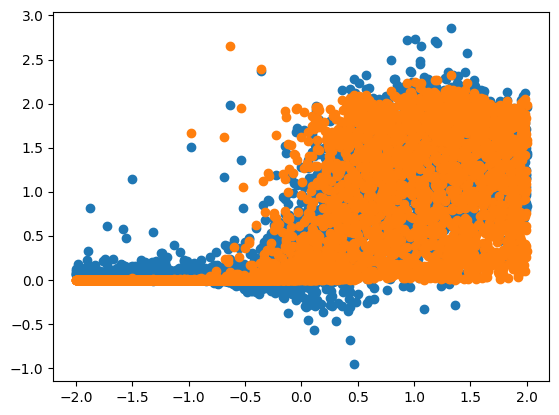

In [3]:
plt.scatter(x, res.post_mean)
plt.scatter(x, res_spike.post_mean)

In [13]:
print(torch.mean ( (betahat-res.post_mean)**2))
print(torch.mean ( (betahat-res_spike.post_mean)**2))

tensor(0.5641)
tensor(0.5352)


In [14]:
res_spike.pi_np

array([[7.18005374e-03, 9.71472442e-01, 9.28390771e-04, 1.81648167e-04,
        2.02373918e-02],
       [5.76760530e-01, 2.49378935e-01, 1.19197831e-01, 2.75384262e-02,
        2.71242075e-02],
       [5.96426606e-01, 1.48150697e-01, 2.42332608e-01, 9.15957801e-03,
        3.93042667e-03],
       ...,
       [1.17982395e-01, 7.92428911e-01, 3.83689329e-02, 5.06888051e-03,
        4.61508967e-02],
       [5.77963114e-01, 2.48304144e-01, 1.13211460e-01, 3.04345638e-02,
        3.00867893e-02],
       [5.72088957e-01, 2.49024108e-01, 1.09087691e-01, 3.49824056e-02,
        3.48168053e-02]], shape=(2000, 5), dtype=float32)

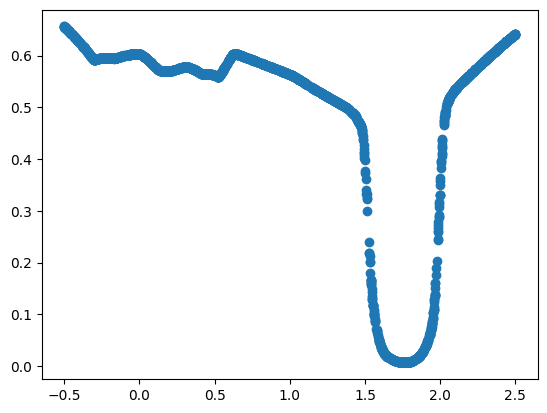

In [15]:
plt.scatter(x,res_spike.pi_np[:,0])

[EMDN] Epoch 10/50, Loss: 0.5987
[EMDN] Epoch 20/50, Loss: 0.1427
[EMDN] Epoch 30/50, Loss: 0.1570
[EMDN] Epoch 40/50, Loss: 0.1479
[EMDN] Epoch 50/50, Loss: 0.1363
[Spiked-EMDN] Epoch 10/50, Loss: 0.9599
[Spiked-EMDN] Epoch 20/50, Loss: 0.1725
[Spiked-EMDN] Epoch 30/50, Loss: 0.1476
[Spiked-EMDN] Epoch 40/50, Loss: 0.1319
[Spiked-EMDN] Epoch 50/50, Loss: 0.1314


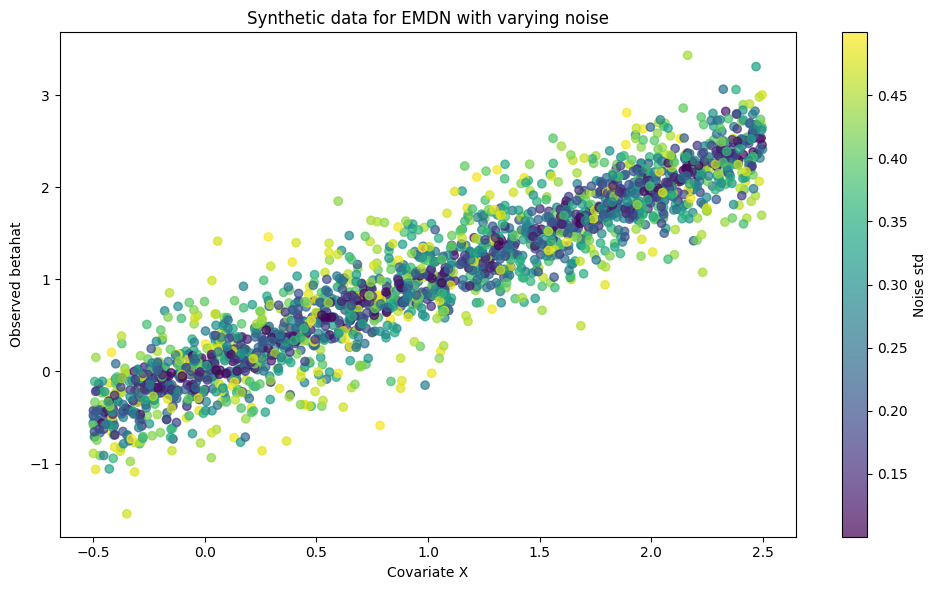

In [17]:
import torch
import matplotlib.pyplot as plt

# -----------------------
# Settings
# -----------------------
torch.manual_seed(1)
device = torch.device("cpu")   # or "cuda"

n_samples = 2000

# -----------------------
# Generate synthetic data
# -----------------------
# Covariates X ~ Uniform(-0.5, 2.5)
X = torch.empty(n_samples, 1, device=device).uniform_(-0.5, 2.5)

# Per-observation noise std ~ Uniform(0.1, 0.5)
obs_noise_std = torch.empty(n_samples, device=device).uniform_(0.1, 0.5)

# Observed betahat = X + noise
betahat = X.squeeze() + obs_noise_std * torch.randn(n_samples, device=device)

# -----------------------
# Call your MDN solvers
# -----------------------
# These functions must already exist in your codebase
# (I assume you've ported them to Torch already)
res_emdn = emdn_posterior_means(
    X, betahat, obs_noise_std 
)
res_spike = spiked_emdn_posterior_means (
    X, betahat, obs_noise_std  
)
# -----------------------
# If you want ASH baseline
# -----------------------
# If you have a Torch version of ASH, call it here; otherwise you’ll still
# need to bridge to your R/Python ASH code.
# For example, if ash() takes numpy arrays:
  
res_ash = ash(betahat , obs_noise_std )

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(10, 6))
plt.scatter(X.cpu().numpy(), betahat.cpu().numpy(),
            c=obs_noise_std.cpu().numpy(),
            cmap='viridis', alpha=0.7)
plt.colorbar(label='Noise std')
plt.xlabel('Covariate X')
plt.ylabel('Observed betahat')
plt.title('Synthetic data for EMDN with varying noise')
plt.tight_layout()
plt.show()


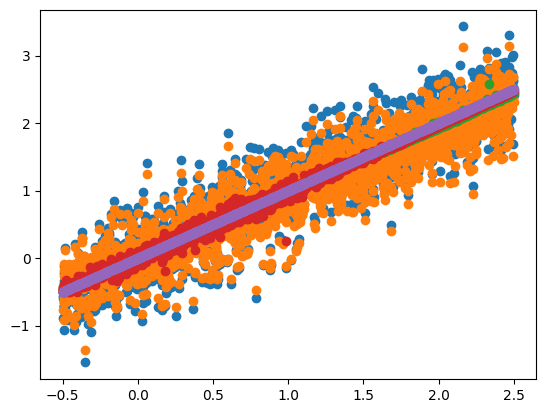

In [18]:
plt.scatter(X.squeeze(), betahat, label='Y obs' ) 
plt.scatter(X.squeeze(), res_ash.post_mean, label='ash' ) 

plt.scatter(X.squeeze(),res_emdn.post_mean, label='post mean mdn' )

plt.scatter(X.squeeze(),res_spike.post_mean, label='post mean mdn' )
plt.scatter(X.squeeze(),X.squeeze(), label='true_mean' )

In [19]:
print(torch.mean ( (betahat-res_emdn.post_mean)**2))
print(torch.mean ( (betahat-res_spike.post_mean)**2))

tensor(0.1016)
tensor(0.0824)


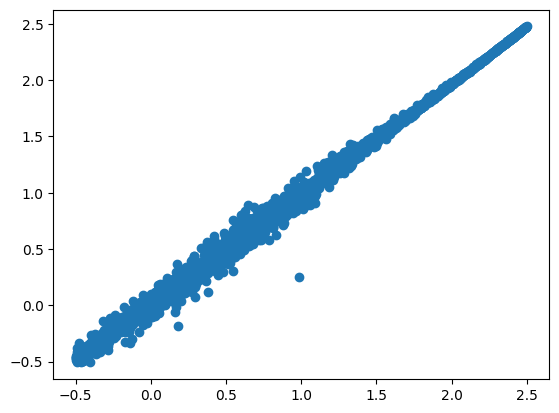

In [20]:

plt.scatter(X.squeeze(),res_spike.post_mean, label='post mean mdn' )

[EMDN] Epoch 10/100, Loss: 1.8251
[EMDN] Epoch 20/100, Loss: 1.7728
[EMDN] Epoch 30/100, Loss: 1.7366
[EMDN] Epoch 40/100, Loss: 1.7274
[EMDN] Epoch 50/100, Loss: 1.7327
[EMDN] Epoch 60/100, Loss: 1.7225
[EMDN] Epoch 70/100, Loss: 1.7164
[EMDN] Epoch 80/100, Loss: 1.7139
[EMDN] Epoch 90/100, Loss: 1.7143
[EMDN] Epoch 100/100, Loss: 1.7084
[Spiked-EMDN] Epoch 10/100, Loss: 1.8480
[Spiked-EMDN] Epoch 20/100, Loss: 1.8329
[Spiked-EMDN] Epoch 30/100, Loss: 1.8059
[Spiked-EMDN] Epoch 40/100, Loss: 1.7651
[Spiked-EMDN] Epoch 50/100, Loss: 1.7469
[Spiked-EMDN] Epoch 60/100, Loss: 1.7429
[Spiked-EMDN] Epoch 70/100, Loss: 1.7358
[Spiked-EMDN] Epoch 80/100, Loss: 1.7303
[Spiked-EMDN] Epoch 90/100, Loss: 1.7292
[Spiked-EMDN] Epoch 100/100, Loss: 1.7272


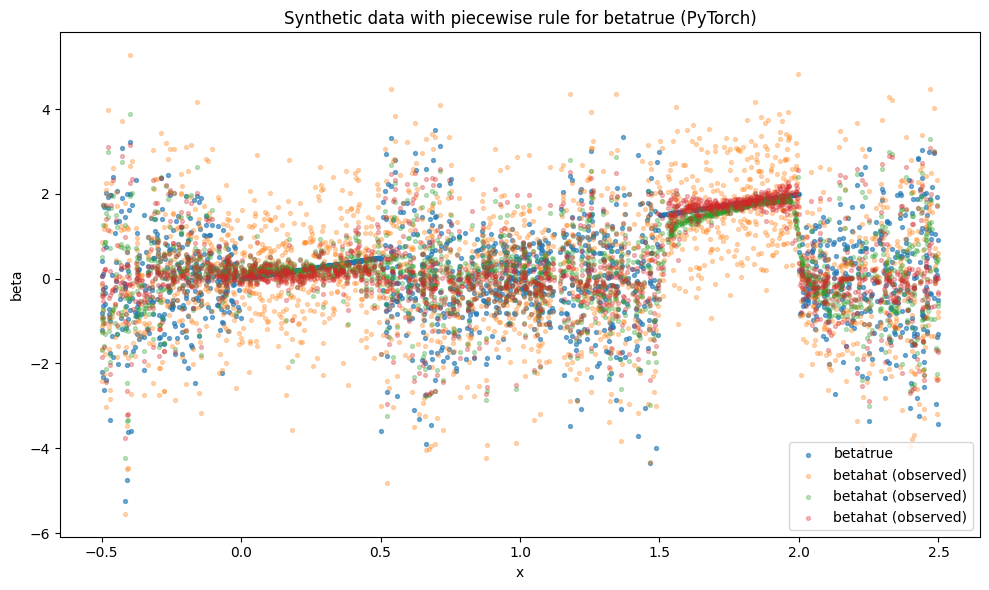

In [10]:
import torch
import matplotlib.pyplot as plt

# If your project functions are torch-based and already on PYTHONPATH, import them:
# from empirical_mdn import *
# from uni_mod_empirical_mdn import *

# -----------------------
# Settings
# -----------------------
torch.manual_seed(1)
device = torch.device("cpu")  # or "cuda"
n_samples = 2000

# -----------------------
# Generate covariate x and X
# x ~ Uniform(-0.5, 2.5)
# -----------------------
x = torch.empty(n_samples, device=device).uniform_(-0.5, 2.5)  # shape (N,)
X = x.view(-1, 1)                                             # shape (N,1)

# -----------------------
# Generate betatrue with your conditional rule
# if (0 < x < 0.5) OR (1.5 < x < 2): betatrue = x
# else: betatrue ~ Normal(0, scale = 0.5 + 1*|sin(pi*x)|)
# -----------------------
cond1 = (x > 0.0) & (x < 0.5)
cond2 = (x > 1.5) & (x < 2.0)
mask = cond1 | cond2

scale_else = 0.5 + torch.abs(torch.sin(torch.pi * x))         # shape (N,)
noise_else = torch.normal(mean=torch.zeros_like(x), std=scale_else)

betatrue = torch.where(mask, x, noise_else)                   # shape (N,)
  
res_ash = ash(betahat , obs_noise_std )

# -----------------------
# Observed data
# betahat = betatrue + Normal(0, 1)
# obs_noise_std = 1 for all i
# -----------------------
obs_noise_std = torch.ones_like(x, device=device)
betahat = betatrue + torch.randn_like(x) * obs_noise_std

# -----------------------
# Call your MDN solvers (must already exist in your codebase)
# -----------------------
 

res = emdn_posterior_means(
    X, betahat, obs_noise_std,
    n_epochs=100,  
)
res_spike = spiked_emdn_posterior_means (
    X, betahat, obs_noise_std,
    n_epochs=100, penalty=1.01
)
# -----------------------
# Optional: ASH baseline (if your ash() expects NumPy arrays)
# -----------------------
# from ash import ash
# res_ash = ash(betahat.cpu().numpy(), obs_noise_std.cpu().numpy())

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(10, 6))
plt.scatter(x.cpu().numpy(), betatrue.cpu().numpy(), s=8, alpha=0.6, label="betatrue")
plt.scatter(x.cpu().numpy(), betahat.cpu().numpy(), s=8, alpha=0.3, label="betahat (observed)")
plt.scatter(x.cpu().numpy(),res.post_mean.cpu().numpy(), s=8, alpha=0.3, label="betahat (observed)")
plt.scatter(x.cpu().numpy(),res_spike.post_mean.cpu().numpy(), s=8, alpha=0.3, label="betahat (observed)")

plt.xlabel("x")
plt.ylabel("beta")
plt.title("Synthetic data with piecewise rule for betatrue (PyTorch)")
plt.legend()
plt.tight_layout()
plt.show()


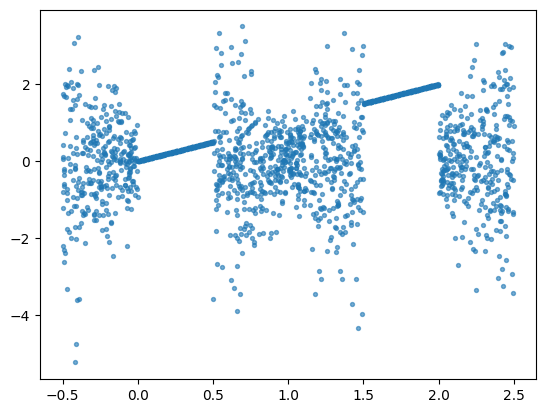

In [11]:
plt.scatter(x.cpu().numpy(), betatrue.cpu().numpy(), s=8, alpha=0.6, label="betatrue")

In [12]:
print(torch.mean ( (betahat-res.post_mean)**2))
print(torch.mean ( (betahat-res_spike.post_mean)**2))

tensor(0.5641)
tensor(0.5352)
